In [1]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
import matplotlib.pyplot as plt
import seaborn as sns
from mol2vec.features import mol2alt_sentence, MolSentence, DfVec, sentences2vec
from mol2vec.helpers import depict_identifier, plot_2D_vectors, IdentifierTable, mol_to_svg
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
import math

In [2]:
# Previous lines are to test the Word2Vec model
# Code starts here
# Reading Hansen and SMILES data from gpHSP
gpHSP_data = pd.read_csv('/Users/jiayun/Documents/work/mol2vec/hansen_1k_smiles_shorter.csv')

mol_smiles = gpHSP_data['SMILES']
hansen_d = gpHSP_data['hansen_d']
hansen_p = gpHSP_data['hansen_p']
hansen_h = gpHSP_data['hansen_h']
mol_number = gpHSP_data['number']
mol_name = gpHSP_data['Molecule']

# hansen_total = np.sqrt((hansen_d*hansen_d + hansen_p*hansen_p + hansen_h*hansen_h))

In [3]:
from gensim.models import word2vec

In [4]:
model = word2vec.Word2Vec.load('mol2vec/examples/models/model_300dim.pkl')

In [5]:
# Extraction of identifiers from molecules
mmm = [Chem.MolFromSmiles(x) for x in mol_smiles]
aa_sentences = [mol2alt_sentence(x, 1) for x in mmm]

In [6]:
#Generate "molecular sentences" that are then used to featurize the molecules 
#(i.e. vectors of identifiers are extracted from Mol2vec model and summed up)
 
aa_mol2vec = [DfVec(x) for x in sentences2vec(aa_sentences, model, unseen='UNK')]

In [7]:
np_aa_mol2vec = np.array([x.vec for x in aa_mol2vec])

In [8]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
from torch.utils.data import TensorDataset, DataLoader

In [9]:
#convert data to tensor
mol2vec_tensors = torch.from_numpy(np_aa_mol2vec)

# convert hansen_d to tensor
np_hansen_d = np.asarray(hansen_d)
tensor_d = torch.from_numpy(np_hansen_d)

# convert mol_name to tensor
np_mol_number = np.asarray(mol_number)
tensor_mol_number = torch.from_numpy(np_mol_number)

In [10]:
# standalise mol2vec tensor data
means = mol2vec_tensors.mean(dim=1, keepdim=True)
stds = mol2vec_tensors.std(dim=1, keepdim=True)
mol2vec_tensors_normalized = (mol2vec_tensors - means) / stds

In [11]:
#print(tensor_d.shape)
new_shape=(len(tensor_d),1)
tensor_d = tensor_d.view(new_shape)

# Define dataset
hansen_d_dataset = TensorDataset(mol2vec_tensors_normalized,tensor_d, tensor_mol_number) 

In [12]:
# create random split of data for traning and validation
from torch.utils.data import random_split, ConcatDataset


ds1, ds2, ds3, ds4, ds5, ds6 = random_split(hansen_d_dataset, [183, 200, 200, 200, 200, 200])

# save dataset
torch.save(ds1, 'hansen_d_ds1.pt')
torch.save(ds2, 'hansen_d_ds2.pt')
torch.save(ds3, 'hansen_d_ds3.pt')
torch.save(ds4, 'hansen_d_ds4.pt')
torch.save(ds5, 'hansen_d_ds5.pt')
torch.save(ds6, 'hansen_d_ds6.pt')

In [13]:
batch_size = 64
num_epochs = 100
learning_rate = 1e-4

In [14]:
# Define data loader

train_ds = ConcatDataset ([ds1, ds2, ds3, ds4])

train_dl = DataLoader(train_ds, batch_size, shuffle=False, num_workers=1)
val_dl = DataLoader(ds5, batch_size, shuffle=False, num_workers=1)
test_dl = DataLoader(ds6, batch_size, shuffle=False, num_workers=1)

In [15]:
# define FFNN

class FFNN(nn.Module):
    def __init__(self):
        super(FFNN, self).__init__()
        self.layers = nn.Sequential(
             nn.Linear(300,200),
             nn.ReLU(),
             nn.Dropout(p=0.25),
             nn.Linear(200,100),
             nn.ReLU(),
             nn.Dropout(p=0.1),
             nn.Linear(100,10),
             nn.ReLU(),
             nn.Dropout(p=0.05),
             nn.Linear(10,1)
         )
    def forward(self, x):
            output = self.layers(x)
            return output

In [16]:
# Initialte model
ffnn_model = FFNN()

# Define cpu/gpu 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
print("The model will be running on", device, "device\n") 

# Convert model parameters and buffers to CPU or Cuda 
ffnn_model.to(device)    

The model will be running on cpu device



FFNN(
  (layers): Sequential(
    (0): Linear(in_features=300, out_features=200, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=200, out_features=100, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=100, out_features=10, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.05, inplace=False)
    (9): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [17]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(ffnn_model.parameters(), lr= learning_rate)

In [18]:
# Utility function to train the model
train_losses=[]

def ffnn_train(num_epochs):
    print ('\nEpoch : %d'%epoch)
    ffnn_model.train()

    running_loss=0
    
    # Train with batches of data
    for xb,yb,zb in train_dl:
        
        # Forward pass
        preds = ffnn_model(xb).double()
        # Compute Loss
        loss = criterion(preds, yb)       
        # clear gradients
        optimizer.zero_grad()  
        # Backward pass to get gradients
        loss.backward()
        # Update parameters
        optimizer.step()
        
        running_loss += loss.item()
        
    train_loss_per_epoch = running_loss/len(train_dl)
    train_losses.append(train_loss_per_epoch)
    print ('Train Loss: %.3f'%(train_loss_per_epoch))  

In [19]:
# evaluate the model on the test set  
eval_losses=[]

predictions = []
actuals = []
r2_all = []
np_predictions_all = []
np_actuals_all = []

def ffnn_evaluate(num_epochs):
    ffnn_model.eval()
    
    running_loss_eval=0
    predictions = []
    actuals =[]

    with torch.no_grad():       
        # iterate. through validating dateset
        for xb,yb,zb in val_dl:   
            preds_eval = ffnn_model(xb).double()
            # compute loss
            loss_eval = criterion(preds_eval, yb)
            #loss list
            running_loss_eval += loss_eval.item()
            
            # retrieve numpy array and save predicted values
            preds_mod = preds_eval.detach().numpy()
            actual = yb.detach().numpy()
            predictions.append(preds_mod)
            actuals.append(actual)

    np_predictions = np.concatenate(predictions, axis=0)
    np_actuals = np.concatenate(actuals, axis=0)
    r2_per_epoch = r2_score(np_actuals, np_predictions)
    
    np_predictions_all.append(np_predictions)
    np_actuals_all.append(np_actuals)
    r2_all.append(r2_per_epoch)
    
    eval_loss_per_epoch = running_loss_eval/len(val_dl)
    eval_losses.append(eval_loss_per_epoch)        
    print('Validate Loss: %.3f'%(eval_loss_per_epoch))   
    print('Validate R2: %.3f'%(r2_per_epoch))

In [20]:
for epoch in range(1, num_epochs+1):
    ffnn_train(epoch)
    ffnn_evaluate(epoch)


Epoch : 1
Train Loss: 301.602
Validate Loss: 304.745
Validate R2: -92.946

Epoch : 2
Train Loss: 299.662
Validate Loss: 303.172
Validate R2: -92.457

Epoch : 3
Train Loss: 297.558
Validate Loss: 300.431
Validate R2: -91.611

Epoch : 4
Train Loss: 293.040
Validate Loss: 293.471
Validate R2: -89.453

Epoch : 5
Train Loss: 283.382
Validate Loss: 279.454
Validate R2: -85.116

Epoch : 6
Train Loss: 265.526
Validate Loss: 257.103
Validate R2: -78.205

Epoch : 7
Train Loss: 239.147
Validate Loss: 226.068
Validate R2: -68.601

Epoch : 8
Train Loss: 202.840
Validate Loss: 185.338
Validate R2: -55.986

Epoch : 9
Train Loss: 160.098
Validate Loss: 137.135
Validate R2: -41.050

Epoch : 10
Train Loss: 112.834
Validate Loss: 87.743
Validate R2: -25.725

Epoch : 11
Train Loss: 66.960
Validate Loss: 45.892
Validate R2: -12.710

Epoch : 12
Train Loss: 33.454
Validate Loss: 20.096
Validate R2: -4.652

Epoch : 13
Train Loss: 17.277
Validate Loss: 10.479
Validate R2: -1.632

Epoch : 14
Train Loss: 13.705

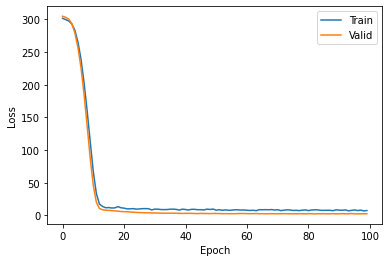

In [21]:
plt.plot(train_losses)
plt.plot(eval_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['Train', 'Valid'])
plt.show()

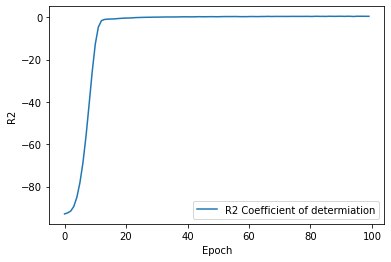

In [22]:
plt.plot(r2_all)
plt.xlabel("Epoch")
plt.ylabel("R2")
plt.legend(['R2 Coefficient of determiation'])
plt.show()

In [23]:
# save the model 
torch.save(ffnn_model.state_dict(), '/Users/jiayun/Documents/work/mol2vec/ffnn_hansen_d_fold1')

# load the model 
# ffnn_model = torch.load(''/Users/jiayun/Documents/work/mol2vec/ffnn_hansen_d_fold1')

In [24]:
#use the model on test data
def test_model(test_dl, ffnn_model):
    predictions_test = []
    actuals_test = []
    molecule_number_test = []
    for xb,yb,zb in test_dl:
        # evaluate the model on the test set  
        preds = ffnn_model(xb).double()
        # retrieve numpy array
        preds = preds.detach().numpy()
        actual = yb.detach().numpy()
        molecule_number = zb.detach().numpy()
        # save data
        predictions_test.append(preds)
        actuals_test.append(actual)
        molecule_number_test.append(molecule_number)
    return predictions_test, actuals_test, molecule_number_test     

In [25]:
predictions_test, actuals_test, molecule_number_test = test_model(test_dl, ffnn_model)

In [26]:
np_predictions_test = np.concatenate(predictions_test, axis=0)
np_actuals_test = np.concatenate(actuals_test, axis=0)
np_molecule_number_test = np.concatenate(molecule_number_test, axis=0)

In [27]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
import math

# MAE, AE and RMSE give an idea of the error distribution
print(mean_absolute_error(np_actuals_test, np_predictions_test))

#RMSEs
print(math.sqrt(mean_squared_error(np_actuals_test, np_predictions_test)))

# R^2 Coefficient of Determination
print(r2_score(np_actuals_test, np_predictions_test))

0.9521358451843263
1.2987217798427542
0.5131172354338339


Text(0, 0.5, 'pred. TSPs')

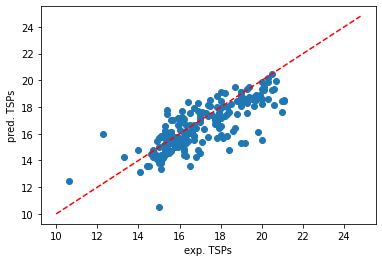

In [29]:
plt.figure(1)

ln = np.arange(10, 25, 0.2)
plt.plot(ln, ln,'r--')
plt.scatter(np_actuals_test, np_predictions_test)
plt.xlabel('exp. TSPs')
plt.ylabel('pred. TSPs')

In [30]:
np_molecule_number_test2 = np_molecule_number_test.reshape(200,1)
pd_mol_number = pd.DataFrame(np_molecule_number_test2, columns = ["number"])
pd_acturals_test = pd.DataFrame(np_actuals_test, columns = ["actual"])
pd_predictions_test = pd.DataFrame(np_predictions_test, columns = ["predict"])
pd_test = pd.concat((pd_mol_number,pd_acturals_test,pd_predictions_test),axis=1)

In [31]:
def mapping(number):
#     print(row['number'])
    return gpHSP_data.loc[gpHSP_data['number'] == number]['SMILES'].iloc[0]

pd_test['SMILES'] = pd_test.apply(lambda row: mapping(row['number']), axis=1)

In [32]:
pd_test

,number,actual,predict,SMILES
0,564,16.8,14.224747,CCSCC
1,528,15.6,14.745420,CCCCCOCCCCC
2,192,16.3,16.242098,CCOCCCl
3,926,16.2,14.377001,CCCCCCCCCCCCCC
4,532,15.8,15.406559,CC(=O)CC(C)(C)O
...,...,...,...,...
195,732,17.4,15.778822,OCC(O)CO
196,1151,15.9,15.046960,COCCOC=C
197,241,19.4,19.467867,Cc1ccccc1N
198,543,17.8,17.247356,CCCCOC(=O)c1ccccc1C(=O)OCCCC
